In [65]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from scipy.ndimage.filters import convolve as filter2D

In [122]:
def translate(img, dx, dy):
    T = np.float32([[1, 0, dx], [0, 1, dy]])
    shifted = cv2.warpAffine(img, T, (img.shape[1], img.shape[0]))
    return shifted


def HornSchunck(img1, img2, lam=1, N_iter=8):
    # Laplacian kernel
    L_kernel = np.array([[1/12, 1/6, 1/12],
                         [1/6,    0, 1/6],
                         [1/12, 1/6, 1/12]], float)
    
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)

    # set up initial velocities
    uInitial = np.zeros([img1.shape[0], img1.shape[1]])
    vInitial = np.zeros([img1.shape[0], img1.shape[1]])

    # Set initial value for the flow vectors
    u = uInitial
    v = vInitial

    # calculate derivatives
    [fx, fy, ft] = calDerivatives(img1, img2)

    for _ in range(N_iter):
        # calculate the average of neighborhood velocity
        u_Avg = filter2D(u, L_kernel)
        v_Avg = filter2D(v, L_kernel)
        der = (fx*u_Avg + fy*v_Avg + ft) / (1 + lam*(fx**2 + fy**2))
        u = u_Avg - fx * der
        v = v_Avg - fy * der

    return u, v


def calDerivatives(img1, img2):
    # kernel for computing d/dx
    X_kernel = np.array([[-1, 1],
                         [-1, 1]]) * .25  

    # kernel for computing d/dy
    Y_kernel = np.array([[-1, -1],
                         [1, 1]]) * .25  

    # kernel for computing frame difference
    T_kernel = np.ones((2, 2))*.25 

    fx = (filter2D(img1, X_kernel) + filter2D(img2, X_kernel)) / 2.0
    fy = (filter2D(img1, Y_kernel) + filter2D(img2, Y_kernel)) / 2.0
    ft = filter2D(img1, T_kernel) + filter2D(img2, -T_kernel)

    return fx, fy, ft


def compareGraphs(u, v, img, lam, scale=5, quivstep=20):
    ax = plt.figure(figsize=(12,12)).gca()
    ax.imshow(img, cmap='gray')
    for i in range(0, u.shape[0], quivstep):
        for j in range(0, v.shape[1], quivstep):
            ax.arrow(j, i, v[i, j]*scale, u[i, j]*scale, color='red',
                     head_width=3, head_length=1,width=0.0001)
    ax.set_title("Lambda:{}".format(lam))


(512, 512)


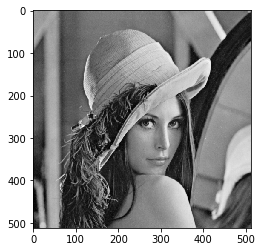

In [36]:
# load original image
PATH = 'lena.bmp'
img = cv2.imread(PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')
print(img.shape)


(512, 512)


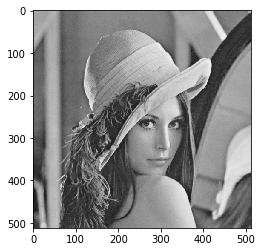

In [37]:
# shift image
img_shifted = translate(img, 1, 1)
plt.imshow(img_shifted, cmap='gray')
print(img_shifted.shape)


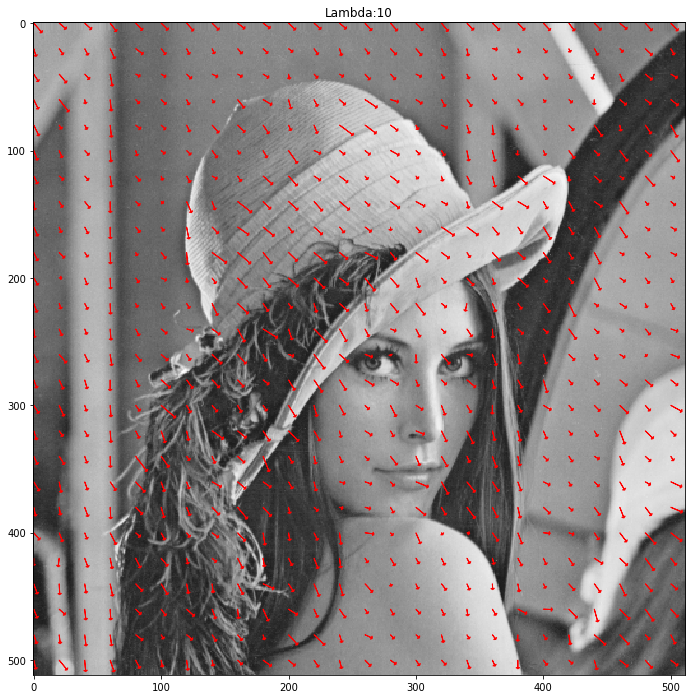

In [123]:
# get optical flow
lam = 10
N_iter=16

u, v = HornSchunck(img, img_shifted, lam=lam, N_iter=N_iter)
compareGraphs(u, v, img_shifted,lam=lam)


In [ ]:
# referaence:
# http://www.sci.utah.edu/~gerig/CS6320-S2013/Materials/CS6320-CV-S2012-OpticalFlow-I.pdf
# http://datahacker.rs/013-optical-flow-using-horn-and-schunck-method/